# A crash course on Network Science with the Python ```networkx``` package

Graph theory is a branch of mathematics devoted to the study of graphs, i.e., mathematical structures uset to model (pairwise) relationships between objects. Despite some unclarity and disagreement on notation and terms, it is generally assumed that graph theory relates to mathematical relationships beteen objects called *nodes* and conenctions between objects called *edges*, while network science is the application of graph theory to practical contexts (such as transportation networks, social networks, etc.). In the latter case, the most common notation is *vertex* instead of nodes and *link* instead of edge. In this crash course, we will stick with the graph theory notation (despite having the term *Network Science* in the title) and we will define a graph $\mathcal{G}$ as 

$\mathcal{G} = (\mathcal{N},\mathcal{E})$

where $\mathcal{N}$ is the set of nodes and $\mathcal{E}$ is the set of edges. This being said, I will use (with a slight abuse of notation) interchangeably graph and network, while I will stick with nodes and edges to define its components. In practical applications, nodes can represent cities, airports, or servers and edges can represent highways connecting cities, direct flights between airports, or amount of data exchanged across servers, respectively. 
Given the aforementioned examples, a first necessary distinction that is important to make regards the nature of the edges. Edges can be *undirected* or *directed*. The distinction mostly relates to the feature that each edge represents in our network. In the first case, the direction of the edge does not matter. This is, for example, the case if edges represent the overall yearly amount of passengers between two airports (e.g., JFK and LAX) irrespective of the direction. In such setting, the feature characterizing the edge is the sum of all passengers flying from JKF to LAX, plus the sum of all passengers flying from LAX to JFK in a given year. Within passenger air traffic, treating edges as undirected is legitimate as, on average, the same amount of passengers flying from A to B will eventually fly back to A.
Some other applications, on the other hand, require a directed approach. This is the case if we want to model urban road networks, where nodes can be road intersections or bus stops, edges road connections between nodes, and travel distance the feature we associate to each edge. Due to the presence of one-way streets and other sources of asymmetry, edges should be directional in this case as the traveling distance from A to B might differ from the traveling distance from B to A.

Before providing an overview of the questions we will be answering as part of this crash course, I want to recommend an excellent introduction to graph theory for those of you who might be interested in understanding more nuances and facets of this beautiful topic:

https://www.amazon.com/Introduction-Graph-Theory-Dover-Mathematics/dp/0486678709

In this crash course, we will be addressing questions such as
* How to properly define a graph (undirected or directed)? How to add nodes (with specific characteristics) and edges (with specific characteristics)?
* How to compute and visualize basic statistics at the node (e.g., degree) or edge level?
* How to compute shortest paths in a network?

and we will do so by relying on the networkx (https://networkx.org/) Python package, that is specifically designed to generate built-in or ad-hoc networks and compute a plethora of features, indicators, indices according to the specific need of the user.

In particular, we will be using a dataset containing the 1,000 highest populated cities in the US (https://github.com/plotly/datasets/blob/master/us-cities-top-1k.csv), and we will learn how to translate such dataset into a network. While nodes are quite straight-forward (each node represents a city), for edges we will assume we are using an electric car with a 1,000 km range. Hence, two cities can be directly connected (i.e., we define an edge connecting the associated nodes) only if their distance is less than 1,000 km. As we assume we can travel in the same way from A to B and vice-versa, we will usean undirected graph.





First, we need to import a few packages. Apart from the usual suspects, we are importing networkx as nx, and the geospatial data visualization package cartopy (https://scitools.org.uk/cartopy/docs/latest/) for the final visualizations.
In terms of pre-requisites, it is assumed a basic knowledge of Python, with a special focus on numpy and pandas, to be able to fully follow this crash course.

In [1]:
# Importing packages

import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from copy import deepcopy
from geopy.distance import great_circle
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')


import networkx as nx

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


We start by setting up the path to the current directory, closing opened figures, and loading the original .csv file as a dataframe

In [2]:
cwd         = os.getcwd()
plt.close('all')

df          = pd.read_csv(os.path.join(cwd,'us-cities-top-1k.csv'), keep_default_na=False)

Let us print a snippet of the dataset to undersand what we are dealing with

In [3]:
df.head()

,City,State,Population,lat,lon
0,Marysville,Washington,63269,48.051764,-122.177082
1,Perris,California,72326,33.782519,-117.228648
2,Cleveland,Ohio,390113,41.499320,-81.694361
3,Worcester,Massachusetts,182544,42.262593,-71.802293
4,Columbia,South Carolina,133358,34.000710,-81.034814


Each row represents a city that is fully represented by its name, state, population, and the (lat,lon) coordinates. As dealing with 1,000 cities might already be time consuming for some of the operations we want to carry out, we will sort the dataframe by descending order of population and focus on the 100 highest populates cities.

In [4]:
df_pop       = df.sort_values(by='Population', ascending=False).reset_index()
n_cities     = 100
df_pop_fltrd = df_pop[:n_cities]

In [5]:
df_pop_fltrd.head(10)

,index,City,State,Population,lat,lon
0,890,New York,New York,8405837,40.712784,-74.005941
1,953,Los Angeles,California,3884307,34.052234,-118.243685
2,594,Chicago,Illinois,2718782,41.878114,-87.629798
3,646,Houston,Texas,2195914,29.760427,-95.369803
4,53,Philadelphia,Pennsylvania,1553165,39.952584,-75.165222
5,966,Phoenix,Arizona,1513367,33.448377,-112.074037
6,153,San Antonio,Texas,1409019,29.424122,-98.493628
7,333,San Diego,California,1355896,32.715738,-117.161084
8,59,Dallas,Texas,1257676,32.776664,-96.796988
9,805,San Jose,California,998537,37.338208,-121.886329


New York is, not surprisingly, the highest populated city in the US, followed by Los Angeles and Chicago. San Jose closes the top-10

We now compute the distance matrix between all 100 cities (this is where using the original datset with 1,000 cities we might have to wait a bit longer!). Note that, due to symmetry, we only fill in the upper triangular part of the matrix and then add the transpose matrix to complete the distance matrix 

In [6]:
dist_matrix = np.zeros([len(df_pop_fltrd),len(df_pop_fltrd)])

for idx_1 in range(0,len(df_pop_fltrd)-1):
    for idx_2 in range(idx_1+1,len(df_pop_fltrd)):
        dist_matrix[idx_1][idx_2] = great_circle((df_pop_fltrd.loc[idx_1]['lat'],df_pop_fltrd.loc[idx_1]['lon']),
                                                 (df_pop_fltrd.loc[idx_2]['lat'],df_pop_fltrd.loc[idx_2]['lon'])).kilometers

dist_matrix = dist_matrix + np.transpose(dist_matrix)

We now define three dictionaries. The first one maps each city with a numerical index as key, and all the characteristics of that city as values. The indices follow the order of the filtered dataset, hence New York has an index of 0, Los Angeles of 1, etc. The second one maps the name of a city to its associated numerical index, and the third one does the opposite. They will come in handy later in this tutorial  

In [7]:
US_cities_info      = {k:(row.City,row.State,row.Population,row.lat,row.lon) for k,row in df_pop_fltrd.iterrows()}
US_cities_name_idx  = {row.City:k for k,row in df_pop_fltrd.iterrows()} 
US_cities_idx_name  = {v:k for k,v in US_cities_name_idx.items()} 

Below we show an extract of the three dictionaries. For the first one, key 0 is associated to New York. For the second one, if we use "New York" as key we obtain the associated index, i.e., 0. Finally, for the third dictionary, if we use 0 as key, we obrain "New York" as value

In [8]:
print(US_cities_info[0])
print(US_cities_name_idx['New York'])
print(US_cities_idx_name[0])

('New York', 'New York', 8405837, 40.7127837, -74.00594129999999)
0
New York


Now we start constructing our graph. As previosusly mentioned, we want an undirected graph, and hence we use the command ```G = nx.Graph()``` to define an empty undirected graph. In addition, we initialize the empty dictionary ```G.pos = {}``` that will contain the (lat,lon) coordinates of all nodes for plotting purposes.  

In [9]:
G           = nx.Graph()
G.pos       = {}

We now populate our empty graph with nodes. Each node is uniquely identified by a (mandatory) numerical identifier (```idx``` in our code). On top of that, we can add as many additional node characteristics as we want. In this case, we add the name of the city, its state, the population, the latitude and longitude. Note that we separately add the (lon,lat) pair to the ```G.pos = {}``` dictionary as this will make out final visualization a bit easier 

In [10]:
# Add nodes
for idx,city in US_cities_info.items():
    G.add_node(idx,name=city[0],state=city[1],
               population=city[2],lat=city[3],lon=city[4])
    G.pos[idx] = (city[4],
                  city[3])

We now introduce a range limit to assess which edges we should define. We assume a maximum range of 750 km for our eletric car (https://www.cars.com/articles/electric-vehicles-with-the-longest-range-422227/). As such, we consider only connections between cities that are closer than such threshold. We assume that we are on a road trip from a given origin city to a given destination city. We assume we can drive to another city within the range during the day, stop to recharge the battery, have dinner, get some sleep, and continue with the road trip the next day. For each (undirected) defined edge, we need to define the mandatory indices of the starting source and target node (```i``` and ```j``` in the code). For undirected graphs, the order does not matter, while for directed graphs the orser is paramunt to correctly map for directionalty. Because of simmetry and undirectionality, we only define edges where $i<j$. Similarly to nodes, we add some additional edge characteristics such as the two cities the edge connects, and the weight of the edge which, in this case, is the distance. This last value will be paramount when computing shortest paths in the network.
Once our graph $\mathcal{G} = (\mathcal{N},\mathcal{E})$ is defined, its connectivity relationships are fully determined (i.e., which nodes is connected to which nodes). Such connectivity relationships can be stored in the *adjacency matrix* $\mathcal{A}_{|\mathcal{N}|,||\mathcal{N}|}$, which is a binary matrix with the same dimension as the cardinality of the set of nodes $|\mathcal{N}|$. Element $a_{i,j}$ of $\mathcal{A}_{|\mathcal{N}|,||\mathcal{N}|}$ is unitary if there is an edge connecting nodes $i$ and $j$. It follows that the adjacency matrix is always symmetric for an undirected graph, while it is not necessarily symmetric for a directed one. While we can build our own adjacency matrix while defining edges, networkx has a simple command to compute such matrix 


In [11]:
range_limit = 750 # [km]

for i in range(0,len(G.nodes)-1):
    for j in range(i+1,len(G.nodes)):
        if dist_matrix[i][j] <= range_limit:
            G.add_edge(i,j,city_1=US_cities_idx_name[i],city_2=US_cities_idx_name[j],
              distance=dist_matrix[i][j])

In [12]:
A = nx.adjacency_matrix(G, nodelist=None, dtype=None, weight=None)
A

<100x100 sparse matrix of type '<class 'numpy.intc'>'
	with 1778 stored elements in Compressed Sparse Row format>

A is a sparse matrix, but we can easily convert it to a dense matrix if needed

In [13]:
A_dense = A.todense()

Let us check, for example, which cities if New York connected to 

In [14]:
idx_NY = US_cities_name_idx['New York']
idx_neighbors_NY = [idx for idx in range(0,len(G.nodes)) if A_dense[idx_NY,idx]==1]
idx_neighbors_NY


[4, 22, 23, 25, 38, 42, 47, 61, 67, 68, 72, 73, 80, 81, 85, 90, 98]

In [15]:
for idx_city in idx_neighbors_NY:
    print(US_cities_idx_name[idx_city])

Philadelphia
Washington
Boston
Baltimore
Virginia Beach
Raleigh
Cleveland
Pittsburgh
Greensboro
Newark
Buffalo
Jersey City
Norfolk
Durham
Winston-Salem
Chesapeake
Richmond


We can obtain the same results using the pre-defined function ```neighbors``` of networkx, which would e my suggestion. Note that for directed graphs, we will have two types of neighbors (in and out). See below the definition of in- and out-degree for directed graphs.

In [16]:
idx_neighbors_NY = G.neighbors(idx_NY)
idx_neighbors_NY = list(idx_neighbors_NY)
idx_neighbors_NY

[4, 22, 23, 25, 38, 42, 47, 61, 67, 68, 72, 73, 80, 81, 85, 90, 98]

Now that we have defined our graph, we can start analyzing some basic characteristics. When analyzing any graph, a good recommendation is to start analyzing the degree. The degree of a node $i$ is defined as $\sum_{i=1}^{|\mathcal{N}|}a_{i,j}$ for an undirected graph and maps how many edges spawn from that node. For a directed graph, the have two different degrees, namely the in- and out-degree. The former is defined as $\sum_{j=1}^{|\mathcal{N}|}a_{j,i}$ and defines the number of edges pointing to node $i$. The latter is defined as $\sum_{j=1}^{|\mathcal{N}|}a_{i,j}$ and defines the number of edges spawning from node $i$. For our undirected graph, we can compute the degree using the function ```nx.degree(G)``` that returns a dictionary-like structure called ```DegreeView```. We translate that into a formal dictionary where the key is the node index, and the value the degree. We then sort values by decreasing order using the ```lambda``` function (where the ```-x[1]``` command is sorting bt descending order), creating a lsit of tuples in the form (airport_idx,degree)     

In [17]:
degree     = dict(nx.degree(G))
degree_srt = sorted(degree.items(), key=lambda x: (-x[1], x[0]))

# Plotting first n cities for degree
n = 5
for i in range(0,n):
    print('%i: %s has a degree of %i'%(i+1,US_cities_idx_name[degree_srt[i][0]],degree_srt[i][1]))
    
nx.degree(G)

1: Cleveland has a degree of 29
2: Columbus has a degree of 28
3: Los Angeles has a degree of 27
4: Las Vegas has a degree of 27
5: Long Beach has a degree of 27


DegreeView({0: 17, 1: 27, 2: 19, 3: 15, 4: 21, 5: 21, 6: 13, 7: 25, 8: 18, 9: 20, 10: 15, 11: 21, 12: 11, 13: 20, 14: 28, 15: 22, 16: 17, 17: 19, 18: 9, 19: 19, 20: 2, 21: 6, 22: 24, 23: 8, 24: 17, 25: 23, 26: 18, 27: 22, 28: 3, 29: 27, 30: 18, 31: 12, 32: 20, 33: 20, 34: 19, 35: 27, 36: 19, 37: 21, 38: 19, 39: 18, 40: 7, 41: 11, 42: 23, 43: 5, 44: 20, 45: 7, 46: 16, 47: 29, 48: 17, 49: 18, 50: 10, 51: 26, 52: 6, 53: 0, 54: 6, 55: 27, 56: 27, 57: 20, 58: 27, 59: 11, 60: 27, 61: 27, 62: 0, 63: 20, 64: 25, 65: 8, 66: 22, 67: 26, 68: 17, 69: 18, 70: 27, 71: 12, 72: 22, 73: 17, 74: 25, 75: 18, 76: 7, 77: 6, 78: 21, 79: 11, 80: 19, 81: 24, 82: 17, 83: 18, 84: 27, 85: 27, 86: 21, 87: 18, 88: 5, 89: 20, 90: 19, 91: 21, 92: 13, 93: 18, 94: 21, 95: 27, 96: 20, 97: 4, 98: 23, 99: 27})

In [18]:
degree_srt

[(47, 29),
 (14, 28),
 (1, 27),
 (29, 27),
 (35, 27),
 (55, 27),
 (56, 27),
 (58, 27),
 (60, 27),
 (61, 27),
 (70, 27),
 (84, 27),
 (85, 27),
 (95, 27),
 (99, 27),
 (51, 26),
 (67, 26),
 (7, 25),
 (64, 25),
 (74, 25),
 (22, 24),
 (81, 24),
 (25, 23),
 (42, 23),
 (98, 23),
 (15, 22),
 (27, 22),
 (66, 22),
 (72, 22),
 (4, 21),
 (5, 21),
 (11, 21),
 (37, 21),
 (78, 21),
 (86, 21),
 (91, 21),
 (94, 21),
 (9, 20),
 (13, 20),
 (32, 20),
 (33, 20),
 (44, 20),
 (57, 20),
 (63, 20),
 (89, 20),
 (96, 20),
 (2, 19),
 (17, 19),
 (19, 19),
 (34, 19),
 (36, 19),
 (38, 19),
 (80, 19),
 (90, 19),
 (8, 18),
 (26, 18),
 (30, 18),
 (39, 18),
 (49, 18),
 (69, 18),
 (75, 18),
 (83, 18),
 (87, 18),
 (93, 18),
 (0, 17),
 (16, 17),
 (24, 17),
 (48, 17),
 (68, 17),
 (73, 17),
 (82, 17),
 (46, 16),
 (3, 15),
 (10, 15),
 (6, 13),
 (92, 13),
 (31, 12),
 (71, 12),
 (12, 11),
 (41, 11),
 (59, 11),
 (79, 11),
 (50, 10),
 (18, 9),
 (23, 8),
 (65, 8),
 (40, 7),
 (45, 7),
 (76, 7),
 (21, 6),
 (52, 6),
 (54, 6),
 (77, 6

We see that the cities with most connections are either in Ohio or in California/Nevada. When plotting the network, we will elaborate a bit more why this result is expected. We can plot the overall degree distribution as follows

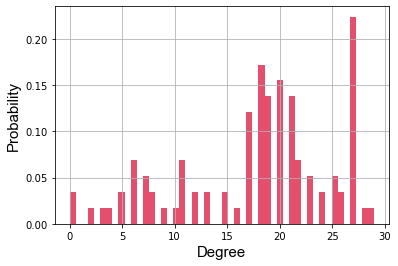

In [19]:
# Defining font for plots and some colors
axis_font = {'fontname':'Arial','fontsize':15}
dark_green   = '#306754'
pale_green   = '#3CB371'
yellow       = '#FFD700'
light_orange = '#FFAE42'
orange_red   = '#AA6C39'
crimson      = '#DC143C'

# Plotting histogram of degree distribution
%matplotlib inline
fig,ax = plt.subplots()
degree_list = [d[1] for d in degree_srt]
n, bins, patches = plt.hist(degree_list, 50, density=True, facecolor=crimson, alpha=0.75)
plt.xlabel('Degree',**axis_font)
plt.ylabel('Probability',**axis_font)
plt.grid(True)
plt.show()

Apart from an outlier on the right, it seems like the degree distribution follows a normal distribution.

Another interesting indicator we can compute once $\mathcal{G}$ is defined is the *network density*. This is defined as the ratio between the edges present in the network, and the maximum number of edges the network under scrutiny could have. For a directed network, any node could be connected to any other node, hence leading to an overall number of edges equal to $|\mathcal{N}|(|\mathcal{N}|-1)$. For an undirected network, we should divide that number by 2 as we lose the notion of directionality. Hence, for an undirected graph the network density is $\frac{|\mathcal{E}|}{|\mathcal{N}|(|\mathcal{N}|-1)/2}$ 

In [20]:
density = nx.density(G)
density

0.1795959595959596

Let us verify the value using the formula introduced above

In [21]:
density_check = len(G.edges)/(len(G.nodes)*(len(G.nodes)-1)/2)
density_check

0.1795959595959596

Finally, another important aspect of every network is the assessment of how *central* every node is. While the concept of centrality encompassess dozens of different variants, one of the most common definitions relates to *betweenness centrality*. This node-specific indicator highlights how often a specific node appears when we move from a certain origin to a certain destination using the available shortest path. In principle, the higher the value, the more *central* the node is, mening it is more likely to gothrough it when moving across the network (trying to minimize the traveled distance while moving from the intended source to the intended target node). We define the betweenness centrality of node $i$ ($c_{B}(i)$) as follows

$c_{B}(i) = \sum_{(s,t) \in \mathcal{N} \times \mathcal{N} | s \neq i \land t \neq i} \frac{\sigma(s,t|i)}{\sigma(s,t)}$

where we cycle over all pairs of (source,target) nodes that neither start nor end in $i$, and where $\sigma(s,t|i)$ is the number of shortest paths from $s$ to $t$ containin $i$, while $\sigma(s,t)$ is the overall number of shortest paths from $s$ to $t$. Note that, given a specific (source,target)pair, there could be more than one shortest path according to the case-specific definition of *shortest*. The aforementioned formula is not normalized. If we want to normalize it, we should consider that if we fix a node $i$, the overall number of $(s,t)$ combinations such that $s \neq i \land t \neq i$ is $(|\mathcal{N}|-1)(|\mathcal{N}|-2)/2$. We have $(|\mathcal{N}|-1)(|\mathcal{N}|-2)$ as we cannot consider $i$ as possible origin (hence the term $(|\mathcal{N}|-1)$), and we cannot consider $i$ or $s$ as destination (hence the term $(|\mathcal{N}|-2)$). Finally, we divide by 2 as the shortest path(s) from $s$ to $t$ and from $t$ to $s$ are equivalent because of the lack of directionality (recall we are consider an undirected graph in our example. If the graph was directed, we would drop the 2). Hence, the normalized version of our betweenness centrality for an undirected graph is

$c_{B}^{norm}(i) = \frac{\sum_{(s,t) \in \mathcal{N} \times \mathcal{N} | s \neq i \land t \neq i} \frac{\sigma(s,t|i)}{\sigma(s,t)}}{(|\mathcal{N}|-1)(|\mathcal{N}|-2)/2}$

Let us compute the normalized betweenness centrality for our network as follows

In [30]:
btw     = dict(nx.betweenness_centrality(G,normalized=True,weight='distance'))
btw_srt = sorted(btw.items(), key=lambda x: (-x[1], x[0])) 
# Plotting first n cities for betweenness
n = 5
for i in range(0,n):
    print('%i: %s (%s) has a normalized betweenness of %f'%(i+1,US_cities_idx_name[btw_srt[i][0]],
           G.nodes[btw_srt[i][0]]['state'],btw_srt[i][1]))

1: Albuquerque (New Mexico) has a normalized betweenness of 0.404659
2: Lubbock (Texas) has a normalized betweenness of 0.339930
3: Memphis (Tennessee) has a normalized betweenness of 0.190682
4: Glendale (Arizona) has a normalized betweenness of 0.176871
5: Scottsdale (Arizona) has a normalized betweenness of 0.152752


We see that the top-5 cities that appear most often in shortest paths are, with the expection of Memphis, in the Soutuwest (New Mexico, Texas, Arizona). Now it is a good time to visualize our graph and assess if results in terms of top cities for degree and betweenness make sense.

To plot our network, we will use the ```cartopy``` package for the geospatial representation of the US, and our ```networkx``` graph to superimpose ndoes and edges in the right position on the map. 

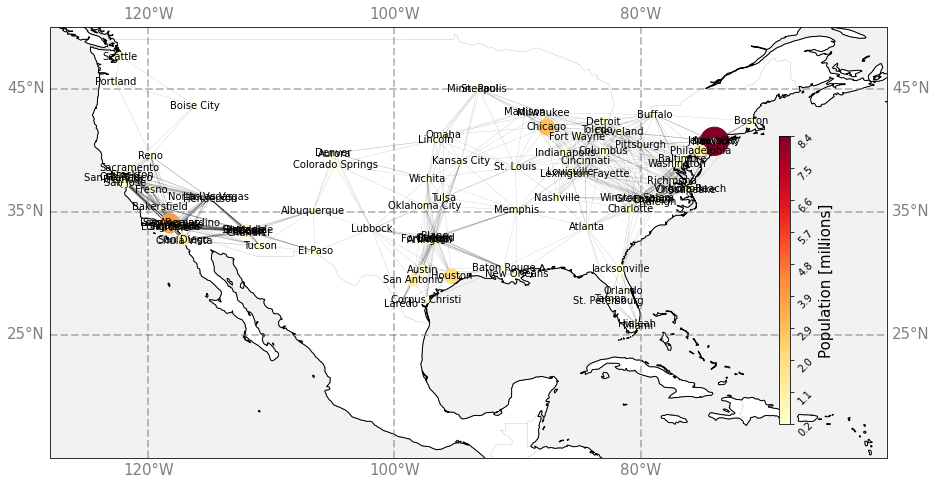

In [31]:
plt.close('all')

# Here we define the radius of each node to be proportional to the population. Hence, the larger the population, the larger the node.
# max_size is the size of the largest node (New York in this case), and was defined via trial and error
max_size = 800
population = [city[2] for k,city in US_cities_info.items()]
nodesize_norm = list(np.abs(np.array(population)/max(population)*max_size))

from matplotlib import cm

# On top of the varying radius, we use a colormap to give a more explicit representation
# of the differences in population size. Each node will be colored proportionally
# to its population usinf the YlOrRd colormap, where lower values are light yellow and
# higher values are dark red
n_blocks  = 10
cmap   = cm.get_cmap('YlOrRd',n_blocks)
cm_colors = cmap(np.arange(0,cmap.N)) 
min_pop = min(population)
max_pop = max(population)
bins         = np.linspace(min_pop,max_pop,n_blocks+1)
color_list = []
for idx,city in US_cities_info.items():
    idx_l = np.where(population[idx]>=bins)[0][-1]
    if idx_l == len(bins)-1:
        idx_l = idx_l-1
    color_list.append(list(cm_colors[idx_l]))

# We also display the name of teh city on top of each node
labels = {idx:row[0] for idx,row in US_cities_info.items()}

# This is where we start our visualization
crs = ccrs.PlateCarree()
fig, ax = plt.subplots(
    1, 1, 
    figsize=(15, 10),
    subplot_kw=dict(projection=crs))
# We add coastlines and other geographical features
ax.coastlines()
ax.add_feature(cartopy.feature.LAND,linewidth=0.1,facecolor='w',alpha=0.9)
ax.add_feature(cartopy.feature.OCEAN,facecolor=(242./255,242./255,242./255))
ax.add_feature(cartopy.feature.COASTLINE,linewidth=0.25)
ax.add_feature(cartopy.feature.BORDERS,linestyle='-',linewidth=0.1,edgecolor='k')
# Here we define the extend of out plow in terms of min lon, max lon, min lat, max lat
ax.set_extent([-128,-60,15,50],
                ccrs.PlateCarree())
# We add gridlines to better assess the position of nodes
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = True
gl.left_labels = True
gl.xlines = True
gl.xlines = True
# We specify the frequency of gridlines (vertical and horizontal)
gl.xlocator = mticker.FixedLocator([-160,-140,-120,-100,-80,-60,-40,-20,0,20,40,60,80,100,120,140,160])
gl.ylocator = mticker.FixedLocator([-65,-45,-25,25,35,45,55])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15, 'color': 'gray', 'weight': 'normal'}
gl.ylabel_style = {'size': 15, 'color': 'gray', 'weight': 'normal'}
# Here we superimpose the nodes on the geographical map. Note the pos=G.pos
# command that places nodes in their (lon,lat) position
nx.draw_networkx(G, ax=ax,
                  font_size=10,
                  alpha=1,
                  width=.075,
                  node_size=nodesize_norm,
                  pos=G.pos,
                  node_color=color_list,
                  labels=labels)
# Here we manually add te colormap mapping the color of each node into population
cax = fig.add_axes([0.80, 0.25, 0.01, 0.4])
cbar = mp.colorbar.ColorbarBase(ax=cax, orientation='vertical', 
                               cmap='YlOrRd')
cbar.set_ticks(np.linspace(0,1,10))
cbar.set_ticklabels(np.round(np.linspace(min_pop,max_pop,10)/1000000,1),rotation=45)
cbar.set_label('Population [millions]', rotation=90, fontsize=15)

Analyzing the plot, we see that both in Ohio and the great lakes area in general and California/Nevada we have a high concentration of cities, hence we extecp some of them to have many connections (high degree). Conversely, New Mexico, Texas, Arizona, and also Tennessee and central states, hence serving as *bridge* cities for shortest path from one coast to the other. Intuitively, it makes sense to see cities in those states with high values of betweenness centrality.

Finally, we mentioned several times the concept of shortest path, and we also mentioned that we want to simulate a road trip from a chosen source city to a chosen target city such that we want to minimize the overall traveled distance. We need a specific ```networkx``` function for this, i.e., ```shortest_path```. This function takes the graph, a source node, a target node, and the specific feature we want to minimize. In our case, we are literally solving a shortest path problem, as we want to minimize the traveled distance (in other cases, it could be time, cost, etc.). 

In [ ]:
source_city = 'Philadelphia'
target_city = 'Los Angeles'

source = US_cities_name_idx[source_city]
target = US_cities_name_idx[target_city]
sp     = nx.shortest_path(G, source=source, target=target, weight='distance', method='dijkstra')

# Print cities part of shortest path
print('')
print('The shortest path from %s to %s is via the following cities: '%(source_city,target_city))
for idx,city_idx in enumerate(sp):
    print('%i: %s (%s)'%(idx+1,US_cities_idx_name[city_idx],
                         G.nodes[city_idx]['state']))
    

# We compute this edgelist as a sequence of tuples (idx_city_1,idx_city_2), where each tuple defines a new edge
# of the computed shortest path. We do so since we want to plot the graph again, b
# but highlighting in red the shortest path 
edgelist = []
for i in range(0,len(sp)-1):
    edgelist.append((sp[i],sp[i+1]))

We now plot again the network, but highlightinng the shortest path between Philadelphia and Los Angeles in red by means of the ```draw_networkx_edges``` function.

In [ ]:
# This is where we start our visualization
crs = ccrs.PlateCarree()
fig, ax = plt.subplots(
    1, 1, 
    figsize=(15, 10),
    subplot_kw=dict(projection=crs))
# We add coastlines and other geographical features
ax.coastlines()
ax.add_feature(cartopy.feature.LAND,linewidth=0.1,facecolor='w',alpha=0.9)
ax.add_feature(cartopy.feature.OCEAN,facecolor=(242./255,242./255,242./255))
ax.add_feature(cartopy.feature.COASTLINE,linewidth=0.25)
ax.add_feature(cartopy.feature.BORDERS,linestyle='-',linewidth=0.1,edgecolor='k')
# Here we define the extend of out plow in terms of min lon, max lon, min lat, max lat
ax.set_extent([-128,-60,15,50],
                ccrs.PlateCarree())
# We add gridlines to better assess the position of nodes
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = True
gl.left_labels = True
gl.xlines = True
gl.xlines = True
# We specify the frequency of gridlines (vertical and horizontal)
gl.xlocator = mticker.FixedLocator([-160,-140,-120,-100,-80,-60,-40,-20,0,20,40,60,80,100,120,140,160])
gl.ylocator = mticker.FixedLocator([-65,-45,-25,25,35,45,55])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15, 'color': 'gray', 'weight': 'normal'}
gl.ylabel_style = {'size': 15, 'color': 'gray', 'weight': 'normal'}
# Here we superimpose the nodes on the geographical map. Note the pos=G.pos
# command that places nodes in their (lon,lat) position
nx.draw_networkx(G, ax=ax,
                  font_size=10,
                  alpha=1,
                  width=.075,
                  node_size=nodesize_norm,
                  pos=G.pos,
                  node_color=color_list,
                  labels=labels)
# This is where we plot the just computed
nx.draw_networkx_edges(G, G.pos, edgelist=edgelist, edge_color='r',width=3, 
                       alpha=1)
# Here we manually add te colormap mapping the color of each node into population
cax = fig.add_axes([0.80, 0.25, 0.01, 0.4])
cbar = mp.colorbar.ColorbarBase(ax=cax, orientation='vertical', 
                               cmap='YlOrRd')
cbar.set_ticks(np.linspace(0,1,10))
cbar.set_ticklabels(np.round(np.linspace(min_pop,max_pop,10)/1000000,1),rotation=45)
cbar.set_label('Population [millions]', rotation=90, fontsize=15)

This concludes the crash course. This is just the tip of the iceberg of course, but I hope it gave you some insights into the potential and capabilities of ```networkx``` and network science in general. Of course, for more information you can always refer to the official webpage (https://networkx.org/) or websites such as stackoverflow. The network science community is huge!